# Desk orientation prediction

In [1]:
import pathlib  # since Python 3.4

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble

%matplotlib inline

We have the floor plan of some building represented on a 2d grid where Xs indicate desks:

In [20]:
floor = pathlib.Path("dataset-example.txt").read_text()
print(floor)

............................
.XXXX.XXXX..XX.XX..XX.XX.X..
.XXXX.XXXX..XX.XX..XX.XX.XX.
............XX.XX..XX.XX.XX.
.XXXX.XXXX..XX.XX..XX.XX.XX.
.XXXX.XXX...XX.XX..XX.XX..X.
............................
............................
.XX.XX..XX.XX..X..XX......X.
.XX.XX..XX.XX..X..XX........
.XX.XX..XX.XX..X..XX..XX....
.XX.XX..XX.XX..X..XX..XX.XX.
.XX.XX..XX.XX..X..XX..XX.XX.
............................



Our goal is to predict the orientation of each desk, in order to help with the implementation of sanitary measures like social distancing.

In [23]:
oriented_floor = predict(floor)
print(oriented_floor)

                            
 ↓↓↓↓ ↓↓↓↓  →← →←  →← →← →  
 ↑↑↑↑ ↑↑↑↑  →← →←  →← →← →← 
            →← →←  →← →← →← 
 ↓↓↓↓ ↓↓↓↓  →← →←  →← →← →← 
 ↑↑↑↑ ↑↑↑   →← →←  →← →←  ← 
                            
                            
 →← →←  →← →←  ?  →←      ? 
 →← →←  →← →←  ?  →←        
 →← →←  →← →←  ?  →←  →←    
 →← →←  →← →←  ?  →←  →← ?? 
 →← →←  →← →←  ?  →←  →← ?? 
                            


Certain desk configurations (single desk, line, square) can have multiple possible orientations so nothing should be predicted there ("?").

The training set should be as minimal as possible. These are the only user-provided patterns:

In [19]:
desks_train = parse_floor(pathlib.Path("dataset-train.txt").read_text())
print(format_desks(desks_train))

         
         
  ↓↓↓    
  ↑↑↑    
         
  ↓↓↓↓↓  
  ↑↑↑↑↑  
         
  ↓      
  ↑↑↑    
         
   ↓     
  ↑↑↑    
         
   ↓↓    
  ↑↑↑    
         
  ↓↓     
   ↑↑    
         
  ↓↓↓↓   
   ↑↑↑↑  
         
         


## Approach 1: direct neighbors

Features: presence of direct neighbors in each cardinal direction.

If same features can lead to different orientations, do not learn and mark the pattern as undecidable.

In [3]:
def simple_features(j, i, presence: np.array):
    north = presence[j-1, i]                     
    north_north = presence[j-2, i]
    east = presence[j, i+1]
    east_east = presence[j, i+2]
    south = presence[j+1, i]
    south_south = presence[j+2, i]
    west = presence[j, i-1]
    west_west = presence[j, i-2]
        
    return (
        north,
        north and north_north,
        east,
        east and east_east,
        south,
        south and south_south,
        west,
        west and west_west,
    )


def fit(desks, get_features):
    model = {}
    undecidable = set()

    augmented_desks = augment_desks(desks)
    _, X, y = floor_features(augmented_desks, get_features)
    
    for x_train, y_true in zip(X, y):
        try:
            if model[x_train] != y_true:
                undecidable.add(x_train)
                del model[x_train]
        except KeyError:
            if x_train not in undecidable:
                model[x_train] = y_true

    return model

In [5]:
simple_model = fit(desks_train, simple_features)
len(simple_model)

24

Max model size is 2**8

In [6]:
floor_test = pathlib.Path("dataset-test.txt").read_text()
print(floor_test)

XXX.XXXX.XXXXX.XXXXXX...
XXX.XXXX.XXXXX.XXXXXX...
........................
XXXXXXX..XXXXXXXXXXXXXXX
XXXXXXX..XXXXXXXXXXXXXXX
........................
XX..XXX..XXXX..XXXXXXXX.
XXX.XXXX.XXXXX.XXXXXXXXX
........................
XX..XXX..XXXX..XXXXXXXX.
.XX..XXX..XXXX..XXXXXXXX
........................
X.X..XX.X.XX.X.XX..XX.XX
XXX.XXXXX.XXXXXXX.XXXXXX
........................
X...X....X.....X........
XXX.XXXX.XXXXX.XXXXXX...
........................
.X...X....X.....X.......
XXX.XXXX.XXXXX.XXXXXX...
........................
.X....X......X.....X...X
XXX.XXXXX.XXXXXXX.XXXXXX
........................
........................
........................
XX....XX..X.X.X.X..XX.XX
XX..X.......X.X.X..X...X
......XXX.....X.X.......
X.X.X.......X...X..X...X
......XXXXX..X..X..XX.XX



In [7]:
print(predict(floor_test, model="simple"))

↓↓↓ ↓↓↓↓ ↓↓↓↓↓ ↓↓↓↓↓↓   
↑↑↑ ↑↑↑↑ ↑↑↑↑↑ ↑↑↑↑↑↑   
                        
↓↓↓↓↓↓↓  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
↑↑↑↑↑↑↑  ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
                        
??  ↓↓↓  ↓↓↓↓  ↓↓↓↓↓↓↓↓ 
↑↑? ↑↑↑? ↑↑↑↑? ↑↑↑↑↑↑↑↑?
                        
??  ?↓↓  ?↓↓↓  ?↓↓↓↓↓↓↓ 
 ??  ↑↑?  ↑↑↑?  ↑↑↑↑↑↑↑?
                        
? ?  ?? ? ?? ? ??  ?? ??
↑?↑ ?↑↑?↑ ↑↑?↑?↑↑ ?↑↑?↑↑
                        
?   ?    ?     ?        
↑?? ↑??? ↑???? ↑?????   
                        
 ?   ?    ?     ?       
?↑? ?↑?? ?↑??? ?↑????   
                        
 ?    ?      ?     ?   ?
?↑? ??↑?? ???↑??? ?↑???↑
                        
                        
                        
??    ??  ? ? ? ?  ?? ??
??  ?       ? ? ?  ?   ?
      ???     ? ?       
? ? ?       ?   ?  ?   ?
      ?????  ?  ?  ?? ??


Correctly predicting common cases, some uncertainty on unusual ones. No false positives (bottom).

Can we do better?

## Approach 2: connected neighborhood

Features: presence of desks in the same "desk island" in a 5x5 neighborhood.

We find the "island" by computing the connected components of the neighborhood's undirected graph.

To build the graph, we compute it's adjacency matrix by summing the neighborhood with shifted neighborhoods along the cardinal axes. Positions equal to 2 indicate adjacency.

In [8]:
def neighbors_along_direction(x, direction, axis):
    xp = np.pad(x, 1)
    neighbors = (xp + np.roll(xp, direction, axis=axis))[1:-1, 1:-1] == 2
    index = np.roll(neighbors, -direction, axis=axis)
    return index.flatten(), neighbors.flatten()

def plane_to_adjacency(x):
    adjacency = np.zeros((x.size, x.size))
    for direction, axis in [(1, 0), (-1, 0), (1, 1), (-1, 1)]:
        index, neighbors = neighbors_along_direction(x, direction, axis)
        adjacency[index, neighbors] = 1
    return adjacency

def only_connected(x):
    adjacency_matrix = plane_to_adjacency(x)
    graph = nx.from_numpy_matrix(adjacency_matrix)
    center = x.size // 2
    connected = list(next(component for component in nx.connected_components(graph) if center in component))
    features = np.zeros(x.size, dtype=x.dtype)
    features[connected] = 1
    return features.reshape(x.shape)

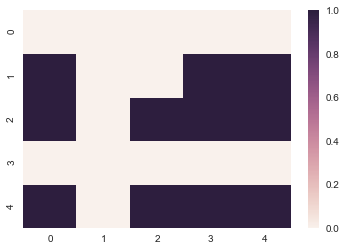

In [9]:
example_neighborhood = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1],
    [1, 0, 1, 1, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 1, 1, 1],
])
sns.heatmap(example_neighborhood)

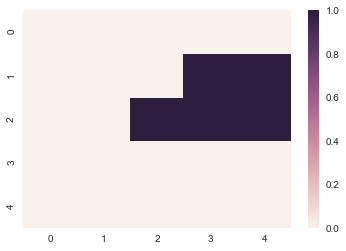

In [10]:
sns.heatmap(only_connected(example_neighborhood))

In [11]:
def advanced_features(j, i, presence):
    neighborhood = presence[j-2:j+3, i-2:i+3]
    neighborhood = only_connected(neighborhood)
    return tuple(neighborhood.flatten())

In [12]:
advanced_model = fit(desks_train, advanced_features)
len(advanced_model)

152

Upper bound is 2**25 but much lower in practice because of connected nature

In [13]:
print(predict(floor_test, model="advanced"))

↓↓↓ ↓↓↓↓ ↓↓↓↓↓ ↓↓↓↓↓↓   
↑↑↑ ↑↑↑↑ ↑↑↑↑↑ ↑↑↑↑↑↑   
                        
↓↓↓↓↓↓↓  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
↑↑↑↑↑↑↑  ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
                        
↓↓  ↓?↓  ↓↓?↓  ↓↓↓↓↓↓?↓ 
↑↑↑ ↑?↑↑ ↑↑?↑↑ ↑↑↑↑↑↑?↑↑
                        
↓↓  ↓??  ↓↓↓↓  ↓↓?↓↓↓?↓ 
 ↑↑  ??↑  ↑↑↑↑  ↑?↑↑↑?↑↑
                        
? ?  ?? ? ↓? ? ?↓  ?? ?↓
??? ↑???? ↑?????↑ ↑????↑
                        
↓   ↓    ↓     ↓        
↑↑↑ ↑??? ↑???? ↑?????   
                        
 ↓   ?    ?     ?       
↑↑↑ ↑??↑ ↑???? ↑?????   
                        
 ↓    ?      ?     ?   ↓
↑↑↑ ↑???↑ ??????? ↑????↑
                        
                        
                        
??    ??  ? ? ? ?  ?? ??
??  ?       ? ? ?  ?   ?
      ???     ? ?       
? ? ?       ?   ?  ?   ?
      ?????  ?  ?  ?? ??


Learning in places where simple model can't, but perhaps surprisingly, unable to predict in places where simple model could because of non-exhaustiveness of training set. Both approaches complimentary. No false positives.

Can we do better ?

## Approach 3: classification

Same features as for approach 2.

In [14]:
def fit_clf(desks):
    augmented_desks = augment_desks(desks)
    _, X, y = floor_features(augmented_desks, advanced_features)
    clf = sklearn.ensemble.RandomForestClassifier()
    clf.fit(X, y)
    return clf

clf_model = fit_clf(desks_train)

In [15]:
print(predict(floor_test, model="clf"))

↓↓↓ ↓↓↓↓ ↓↓↓↓↓ ↓↓↓↓↓↓   
↑↑↑ ↑↑↑↑ ↑↑↑↑↑ ↑↑↑↑↑↑   
                        
↓↓↓↓↓↓↓  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
↑↑↑↑↑↑↑  ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
                        
↓↓  ↓↓↓  ↓↓↓↓  ↓↓↓↓↓↓↓↓ 
↑↑↑ ↑↑↑↑ ↑↑↑↑↑ ↑↑↑↑↑↑↑↑↑
                        
↓↓  ↓↓↓  ↓↓↓↓  ↓↓↓↓↓↓↓↓ 
 ↑↑  ↑↑↑  ↑↑↑↑  ↑↑↑↑↑↑↑↑
                        
↓ ↓  ↓↓ ↓ ↓↓ ↓ ↓↓  ↓↓ ↓↓
↑↑↑ ↑↑↑↑↑ ↑↑↑↑↑↑↑ ↑↑↑↑↑↑
                        
↓   ↓    ↓     ↓        
↑↑↑ ↑↑?? ↑↑??? ↑↑????   
                        
 ↓   ↓    ↓     ↓       
↑↑↑ ↑↑↑↑ ↑↑↑?? ↑↑↑???   
                        
 ↓    ↓      ↓     ↓   ↓
↑↑↑ ↑↑↑↑↑ ??↑↑↑?? ↑↑↑?↑↑
                        
                        
                        
??    ??  ? ? ? ?  ?? ??
??  ?       ? ? ?  ?   ?
      ???     ? ?       
? ? ?       ?   ?  ?   ?
      ?????  ?  ?  ?? ??


Generalizes much better, still some uncertainty in some weird areas (probably best this way).

Caveat: magic threshold of 0.85 to optimize for (max predicted probability), otherwise we get false positives in the bottom area.

In [24]:
orientation_formats = {"N": "↑", "E": "→", "S": "↓", "W": "←", ".": " "}
rotated_orientations = {"N": "W", "E": "N", "S": "E", "W": "S"}
flipped_orientations = {"N": "S", "E": "E", "S": "N", "W": "W"}

def format_desks(desks: np.array):
    return "\n".join("".join(orientation_formats.get(x, x) for x in line) for line in desks)

def parse_floor(floor: str):
    desks = np.array([list(line) for line in floor.splitlines()])
    return np.pad(desks, 2, constant_values=".")
        
def floor_features(desks, get_features):
    def generate():
        desk_presence = (desks != ".").astype(int)
        seen = set()
        for (j, i), y_true in np.ndenumerate(desks):
            if y_true == ".":
                continue

            features = get_features(j, i, desk_presence)
            
            yield (j, i), features, y_true

    coords, X, y = zip(*generate())
    js, iss = zip(*coords)
    
    return (js, iss), X, y

def rotate_desks(desks: np.array):
    return np.array([[rotated_orientations.get(value, value) for value in row] for row in np.rot90(desks)])

def flip_desks(desks: np.array):
    return np.array([[flipped_orientations.get(value, value) for value in row] for row in np.flip(desks, axis=0)])

def augment_desks(desks: np.array):
    rotated = [
        desks,
        rotate_desks(desks),
        rotate_desks(rotate_desks(desks)),
        rotate_desks(rotate_desks(rotate_desks(desks))),
    ]

    verticals = np.concatenate([
        desks,
        rotated[2],
        flip_desks(desks),
        flip_desks(rotated[2]),
    ], axis=1)
    
    horizontals = np.concatenate([
        rotated[1],
        flip_desks(rotated[1]),
        rotated[3],
        flip_desks(rotated[3]),
    ], axis=0)
    
    height1, width1 = verticals.shape
    height2, width2 = horizontals.shape
    
    horizontals = np.pad(horizontals, ((0, 0), (0, width1 - width2)), constant_values=".")

    return np.concatenate((verticals, horizontals), axis=0)

def predict_orientation(desks: np.array, model_name="clf"):
    desks_pred = np.array(desks)
    if model_name == "clf":
        coords, X, _ = floor_features(desks, advanced_features)
        y_pred = clf_model.predict(X)
        max_proba = clf_model.predict_proba(X).max(axis=1)
        y_pred[max_proba < 0.85] = "?"
    elif model_name == "simple":
        coords, X, _ = floor_features(desks, simple_features)
        y_pred = np.array([simple_model.get(x, "?") for x in X])
    elif model_name == "advanced":
        coords, X, _ = floor_features(desks, advanced_features)
        y_pred = np.array([advanced_model.get(x, "?") for x in X])
    elif model_name == "combined":
        coords, X_simple, _ = floor_features(desks, simple_features)
        _, X_advanced, _ = floor_features(desks, advanced_features)
        y_pred = np.array([
            simple_model.get(x_simple) or advanced_model.get(x_advanced) or "?"
            for x_simple, x_advanced in zip(X_simple, X_advanced)
        ])
    desks_pred[coords] = y_pred
    return desks_pred

def predict(floor, model="clf"):
    desks = parse_floor(floor)
    desks_pred = predict_orientation(desks, model)[2:-2, 2:-2]
    return format_desks(desks_pred)

In [91]:
desks_test = parse_floor(pathlib.Path("dataset-test.txt").read_text())
desks_test = augment_desks(desks_test)

for name in ["simple", "advanced", "combined", "clf"]:
    desks_pred = predict_orientation(desks_test, name)[2:-2, 2:-2]
    pred_format = format_desks(desks_pred)
    pathlib.Path(f"pred-{name}.txt").write_text(pred_format)

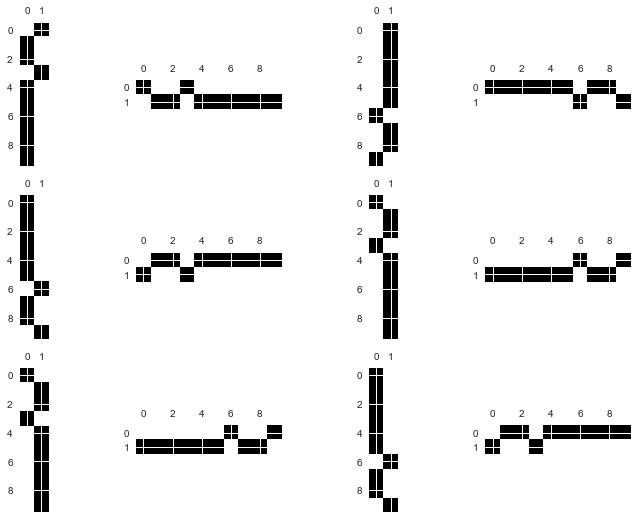

In [74]:
x = np.array([
    [0, 1],
    [1, 0],
    [1, 0],
    [0, 1],
    [1, 0],
    [1, 0],
    [1, 0],
    [1, 0],
    [1, 0],
    [1, 0],    
])

rotated = [
    x,
    np.rot90(x),
    np.rot90(np.rot90(x)),
    np.rot90(np.rot90(np.rot90(x))),
]

fig, axs = plt.subplots(3, 4, figsize=(12, 9))

for i in range(4):    
    axs[0][i].matshow(rotated[i])
    axs[1][i].matshow(np.flip(rotated[i], axis=0))
    axs[2][i].matshow(np.flip(rotated[i], axis=1))

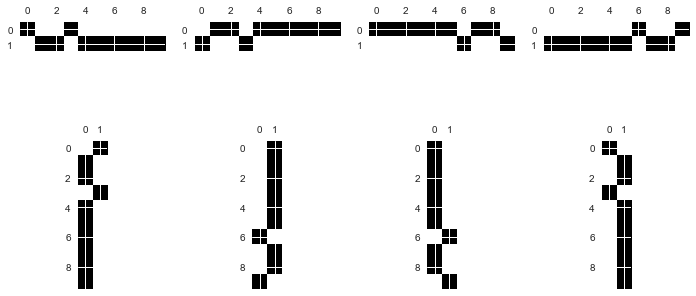

In [75]:
verticals = [
    x,
    rotated[2],
    np.flip(x, axis=0),
    np.flip(rotated[2], axis=0),
]

horizontals = [
    rotated[1],
    np.flip(rotated[1], axis=0),
    rotated[3],
    np.flip(rotated[3], axis=0),
]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    axs[0][i].matshow(horizontals[i])
    axs[1][i].matshow(verticals[i])